# A Practical Guide to Generating New Data with Variational Autoencoders in PyTorch

## What You Will Learn from This Article
- Gain a basic understanding of the theory behind Variational Autoencoders (VAEs).
- Learn how to implement a VAE in PyTorch using the Wine dataset.
- Discover how to combine PCA with VAEs for dimensionality reduction and visualization.
- Learn how to apply a classification method to predict labels for the data generated by the VAE.

## Introduction

A Variational Autoencoder is a special form of autoencoder, and therefore it's a dimensionality reduction method.

In order to really get Variational Autoencoders, we first need to know what dimensionality reduction is and why it’s useful, and also how **regular autoencoders** work, and what their limits are that make them **a bad fit for generative AI**.

<img src="https://www.researchgate.net/profile/Christian-Perron/publication/365126867/figure/fig6/AS:11431281094770406@1667588083021/Taxonomy-of-some-common-dimensionality-reduction-methods-Methods-listed-are-Principal.png" alt="A graph of Dimensionality Reduction Methods" style="margin: auto; display: block;width: 600px;">

Imagine you have a very large dataset with tons of features, and you want to train a machine learning model on it.
How would you select the best features that explain your data the most—especially when you don’t have a deep understanding of its context? There will be some challenges, right?
If you throw in a bunch of features without knowing if they actually matter, you’ll probably end up overfitting. On the other hand, if you use too few features, you might face underfitting. **This is where dimensionality reduction methods come in handy.**

**Dimensionality Reduction** methods allow us to compress the large datasets with tons of features while still keeping pretty much all the important information. In other words, these methods let us turn datasets with lots of features into a new one with fewer features.

### Note: 
If you’ve done some machine learning before, you may have worked with one of the most widely used dimensionality reduction methods called PCA. That’s basically what I mean when I talk about turning a dataset with tons of features into one with fewer.
### what are AutoEncoders?
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/37/Autoencoder_schema.png/330px-Autoencoder_schema.png" alt="an AutoEncoder architecture" style="width: 300;">


Autoencoders are neural networks that learn a compressed latent representation through a nonlinear encoder–decoder architecture. The encoder takes the data, passes it through a few layers, and turns it into a code. This code lives in what’s called the latent space. The size of that latent space is basically the number of features we want our dataset to end up with.

As you see in the picture below, the number of features decreases in each layer until it is compressed into two features.

<img src="./images/autoencoderExample.png" alt="an AutoEncoder graph" style="margin: auto; display: block; width: 600px;">

The decoder part takes the data from the latent space and passes it through several layers to finally reconstruct the original input.

Finally, since we want the reconstructed input to be as close as possible to the original data, we define the following loss function and let the model minimize it.

$loss = \sum_{i}^{N}\left\| x-x^{''}\right\|^{2} = \sum_{i}^{N}\left\| x-d(z)\right\|^{2} = \sum_{i}^{N} \left\| x - d(e(x))\right\|^{2}$

Okay, let’s stop with the theory and actually build an autoencoder to generate some data and see why a vanilla autoencoder is not a good option in genrating samples.

**Note**: We use the Wine dataset, which is available in scikit-learn.

## Importing Necessary Modules and Preprocessing Data

In [1]:
import numpy as np
import pandas as pd
import lightning as L # lightening can simplify the training process,improve code organization,and make it easier to scale.
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset

from sklearn.decomposition import PCA
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Set random seed for reproducibility
L.seed_everything(seed=42, workers=True)

Seed set to 42


42

In [3]:
# Load the Wine dataset
wine = load_wine()
#wine

In [4]:
X = wine.data  # 13 features
y = wine.target  # Target labels

In [5]:
print(X.shape, type(X))

(178, 13) <class 'numpy.ndarray'>


In [6]:
feature_names = wine.feature_names 
feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [7]:
target_names = wine.target_names
target_names

array(['class_0', 'class_1', 'class_2'], dtype='<U7')

In [8]:
# convert X from numpy array to a dataframe
X_df = pd.DataFrame(data=X, columns=feature_names)
X_df.head(5)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [9]:
# check if everything is ok in dataframe
X_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 13 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
dtypes: fl

In [10]:
# check the range of each feature in the data set
# we use this method alot to compare the original data and reconstructed data 
X_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,13.000618,2.336348,2.366517,19.494944,99.741573,2.295112,2.029270,0.361854,1.590899,5.058090,0.957449,2.611685,746.893258
std,0.811827,1.117146,0.274344,3.339564,14.282484,0.625851,0.998859,0.124453,0.572359,2.318286,0.228572,0.709990,314.907474
min,11.030000,0.740000,1.360000,10.600000,70.000000,0.980000,0.340000,0.130000,0.410000,1.280000,0.480000,1.270000,278.000000
25%,12.362500,1.602500,2.210000,17.200000,88.000000,1.742500,1.205000,0.270000,1.250000,3.220000,0.782500,1.937500,500.500000
50%,13.050000,1.865000,2.360000,19.500000,98.000000,2.355000,2.135000,0.340000,1.555000,4.690000,0.965000,2.780000,673.500000
75%,13.677500,3.082500,2.557500,21.500000,107.000000,2.800000,2.875000,0.437500,1.950000,6.200000,1.120000,3.170000,985.000000
max,14.830000,5.800000,3.230000,30.000000,162.000000,3.880000,5.080000,0.660000,3.580000,13.000000,1.710000,4.000000,1680.000000


In [11]:
# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# fit_transform return a numpy array. Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
type(X_tensor)

torch.Tensor

## Create and Train the model
To keep things simple, in this example we use two layers to encode the data. First, the input is turned into a hidden layer, and then that hidden layer is turned into the latent space.Also the decoder just does the opposite of the encoder.

In [12]:
class Autoencoder(L.LightningModule):
    
    ## input_dim: it actully is the number of features(13 features)
    ## hidden_dim: hidden layer dimension
    ## latent_dim: latent_space dimension
    ## learning_rate: used to tune the gradient descent steps
    
    def __init__(self, input_dim, hidden_dim, latent_dim, learning_rate):
        super().__init__()
        
        # the learning rate for gradient decent
        self.learning_rate = learning_rate
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        
        self.loss = nn.MSELoss()
        self.batch_losses = []  # store loss value for each bach
        self.epoc_losses = []  # store average loss for baches in each epoc

            
    def forward(self, input):
        encoded = self.encoder(input) # it returns the compressed data in latent space and store it in the varialbe called 'encoded'
        decoded = self.decoder(encoded) # reconstructed input
        return decoded, encoded

    def configure_optimizers(self):
        ## In this example, configuring the optimizer
        ## consists of passing it the weights and biases we want
        ## to optimize, which are all in self.parameters(),
        ## and setting the learning rate
        return Adam(self.parameters(), lr=self.learning_rate)
        
    def training_step(self, batch, batch_idx):
        ## The first thing we do is split 'batch'
        ## into the input and label values.
        ## Note that here, the labels are the inputs themselves
        inputs, labels = batch

        ## Then we run the input through the neural network
        outputs = self.forward(inputs)
        # outputs[0] = reconstructed input
        # output[1] = latent input
        ## Then we calculate the loss.
        loss = self.loss(outputs[0], labels)

        ## Lastly, we could add the loss for each bach
        ## to a list called batch_losses,
        ## so that we can graph it later. This would
        ## help us decide if we have done enough training
        ## Ideally, if we do enough training, the loss
        ## should be small and not getting any smaller.
        
        self.batch_losses.append(loss.item())
        return loss
        
    ## "on_train_epoch_end" is a hook(event) within the LightningModule that is called at the end of each training epoch.
    def on_train_epoch_end(self):
        # Compute average loss for the epoch
        avg_loss = np.mean(self.batch_losses[-len(train_dataloader):])
        self.epoc_losses.append(avg_loss)

In [13]:
# Initialize model
model = Autoencoder(input_dim=X.shape[1], hidden_dim=8, latent_dim=2, learning_rate=0.01)

In [14]:
# put our training data into a DataLoader
train_dataset = TensorDataset(X_tensor, X_tensor)
train_dataloader = DataLoader(train_dataset, batch_size = 32, num_workers=7, drop_last=True)
len(train_dataloader)

5

In [15]:
# train the model
trainer = L.Trainer(max_epochs=50)
trainer.fit(model, train_dataloaders=train_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 130    | train
1 | decoder | Sequential | 141    | train
2 | loss    | MSELoss    | 0      | train
-----------------------------------------------
271       Trainable params
0         Non-trainable params
271       Total params
0.001     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs fo

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluation
lets first plot the trainning loss to see if we have done enough training

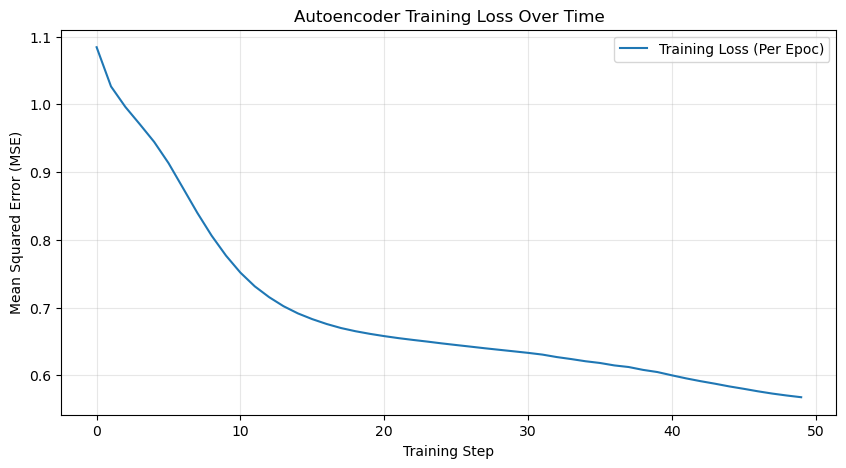

In [16]:
# Plot the training loss
plt.figure(figsize=(10, 5))
plt.plot(model.epoc_losses, label='Training Loss (Per Epoc)')
plt.title('Autoencoder Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Mean Squared Error (MSE)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

As you see above by training more epocs we could have got a better loss, but its small enough so we'll pass.

Now let’s make a DataFrame from the reconstructed data and plot a boxplot to compare it to the original data.

In [17]:
# Get reconstructed and latent data
model.eval()
with torch.no_grad():
    X_recons, X_latent = model(X_tensor)
X_recons = X_recons.numpy()  # Reconstructed data (13 dimensions)
X_latent = X_latent.numpy()  # Latent representations (2 dimensions)

# Inverse transform to original scale for comparison
X_reconstructed = scaler.inverse_transform(X_recons)
X_reconstructed_df = pd.DataFrame(data=X_reconstructed, columns=feature_names)

In [18]:
X_reconstructed_df.head(5) # notice we have shuffled the input in dataloader

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,13.999590,1.979816,2.427207,15.918589,107.680687,3.022248,3.110782,0.289532,1.986876,6.257539,1.073789,3.099347,1234.409424
1,13.536118,1.966444,2.401661,17.452999,104.923668,2.847182,2.883194,0.288601,1.943885,5.235287,1.063484,3.085062,1029.773438
2,13.532314,1.966334,2.401451,17.465588,104.901047,2.845746,2.881327,0.288594,1.943532,5.226899,1.063399,3.084945,1028.094360
3,14.426809,1.992143,2.450755,14.504199,110.222046,3.183621,3.320568,0.290390,2.026504,7.199832,1.083289,3.112514,1423.038940
4,12.938578,1.949203,2.368725,19.431263,101.369141,2.621475,2.589773,0.287401,1.888458,3.917329,1.050197,3.066645,765.942993


In [19]:
X_reconstructed_df.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
count,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000,178.000000
mean,12.865723,2.261988,2.342307,19.588623,98.431221,2.266421,1.997200,0.368793,1.561251,4.598977,0.970733,2.615256,709.000732
std,0.569994,0.341991,0.049908,1.827994,5.554967,0.519197,0.815883,0.084833,0.379229,0.913888,0.093910,0.493090,270.281799
min,12.440277,1.937375,2.289832,13.714535,92.260132,1.605724,0.925137,0.286876,1.028233,3.225021,0.839059,1.913350,483.802094
25%,12.452179,1.966168,2.290027,18.359942,92.342999,1.686730,1.042192,0.288787,1.112555,3.760365,0.853659,2.001194,489.725983
50%,12.495226,2.079756,2.325816,20.831059,97.239983,2.248307,2.053514,0.340714,1.646334,4.755963,0.998688,2.783894,556.821808
75%,13.262173,2.707315,2.386561,20.836575,103.294088,2.743706,2.748674,0.473174,1.918475,4.935575,1.057393,3.076619,908.819397
max,14.665330,2.757907,2.463902,20.915945,111.640907,3.273716,3.437692,0.489897,2.048629,7.725923,1.088592,3.119866,1528.352295


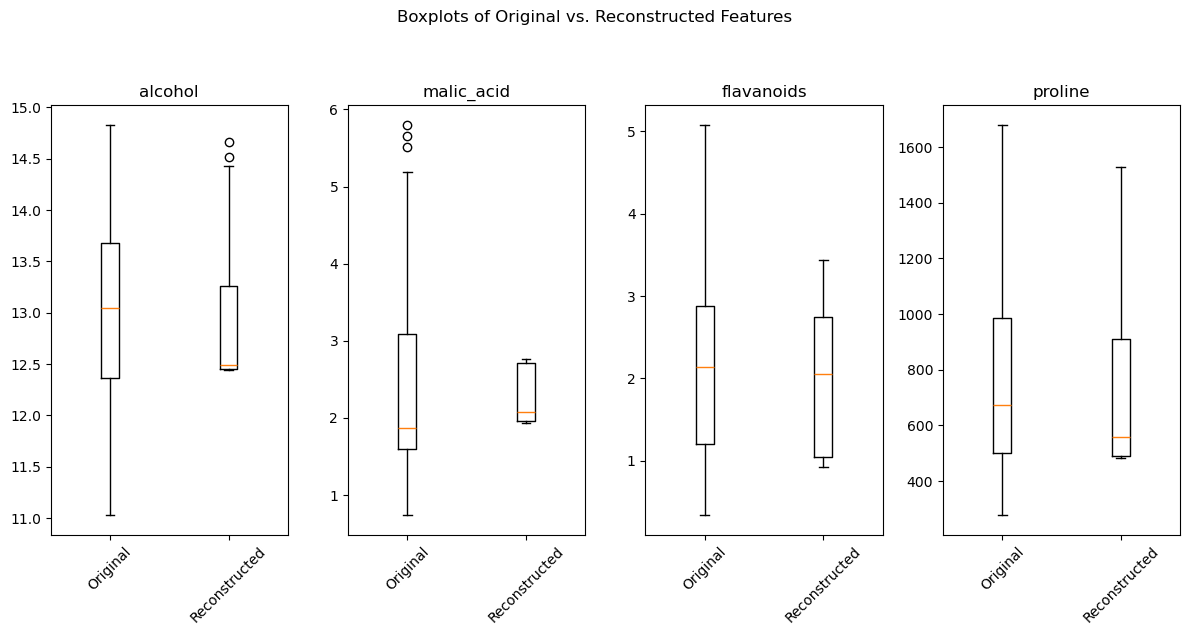

In [20]:
# Boxplots for selected features to compare the reconstructed data with original data
selected_features = [0, 1, 6, 12]  # alcohol, malic acid, flavanoids, proline
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_features):
    plt.subplot(1, len(selected_features), i + 1)
    feature = feature_names[idx]
    plt.boxplot([X_df[feature], X_reconstructed_df[feature]], labels=['Original', 'Reconstructed'])
    plt.title(feature_names[idx])
    plt.xticks(rotation=45)
plt.suptitle('Boxplots of Original vs. Reconstructed Features', y=1.05)
plt.tight_layout()
plt.show()

Based on the boxplot, the model performed well in capturing the central range of the features, but it did poorly in estimating the extreme values. This is somewhat expected, since we compressed 13 features into just 2 features using only two layers. If we increase the number of layers or slightly raise the number of features in the latent space, the model will likely perform more accurately.

We plotted the latent space, as you can see below, the second dimension is always zero. This explains the weak performance of the model, since we had restricted the latent space to only two dimensions. Therefore, let’s increase the number of dimensions to **four** and take another look at these plots

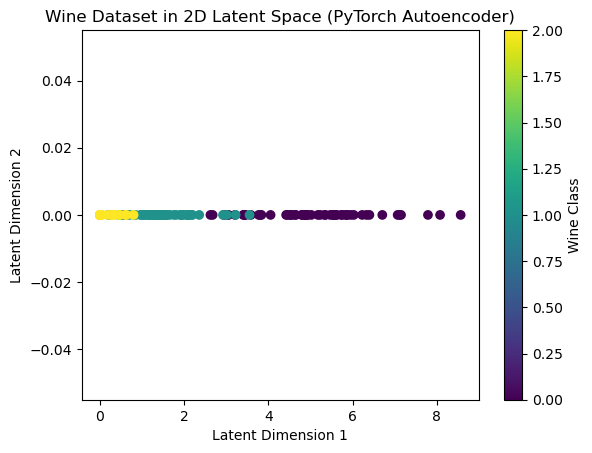

In [21]:
# Visualize the latent data
plt.scatter(X_latent[:, 0], X_latent[:, 1], c=y, cmap='viridis')
plt.title('Wine Dataset in 2D Latent Space (PyTorch Autoencoder)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Wine Class')
plt.show()

In [22]:
# Initialize the model for the second time
model2 = Autoencoder(input_dim=X.shape[1], hidden_dim=8, latent_dim=4, learning_rate=0.01)

In [23]:
# train the model
trainer = L.Trainer(max_epochs=50)
trainer.fit(model2, train_dataloaders=train_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | encoder | Sequential | 148    | train
1 | decoder | Sequential | 157    | train
2 | loss    | MSELoss    | 0      | train
-----------------------------------------------
305       Trainable params
0         Non-trainable params
305       Total params
0.001     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs fo

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [24]:
# Get reconstructed and latent data
model2.eval()
with torch.no_grad():
    X_recons, X_latent = model2(X_tensor)
X_recons = X_recons.numpy()  # Reconstructed data (13 dimensions)
X_latent = X_latent.numpy()  # Latent representations (2 dimensions)

# Inverse transform to original scale for comparison
X_reconstructed = scaler.inverse_transform(X_recons)
X_reconstructed_df = pd.DataFrame(data=X_reconstructed, columns=feature_names)

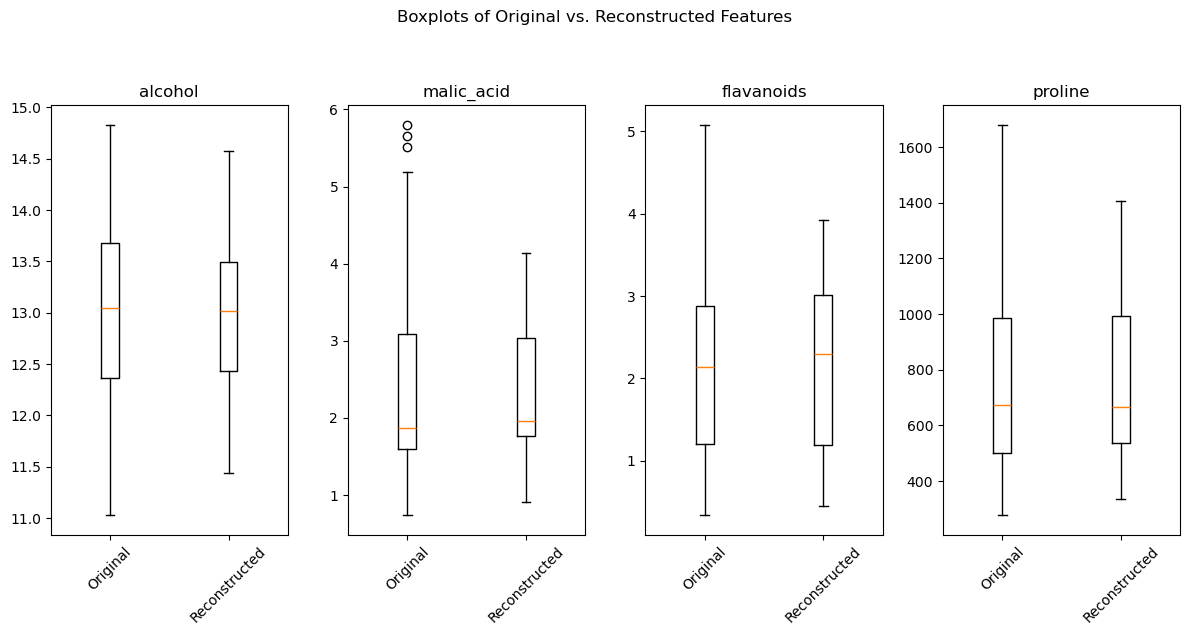

In [25]:
# Boxplots for selected features to compare the reconstructed data with original data
selected_features = [0, 1, 6, 12]  # alcohol, malic acid, flavanoids, proline
plt.figure(figsize=(12, 6))
for i, idx in enumerate(selected_features):
    plt.subplot(1, len(selected_features), i + 1)
    feature = feature_names[idx]
    plt.boxplot([X_df[feature], X_reconstructed_df[feature]], labels=['Original', 'Reconstructed'])
    plt.title(feature_names[idx])
    plt.xticks(rotation=45)
plt.suptitle('Boxplots of Original vs. Reconstructed Features', y=1.05)
plt.tight_layout()
plt.show()

By increasing the number of features in the hidden layer, the model’s performance improved significantly. In this case, the latent space has 4 features, which cannot be directly visualized in two dimensions. Therefore, we use another dimensionality reduction method, called PCA, to project the latent layer data into 2D for visualization.

In [26]:
latentPCA = PCA(n_components=2)
latentScores = latentPCA.fit_transform(X_latent)

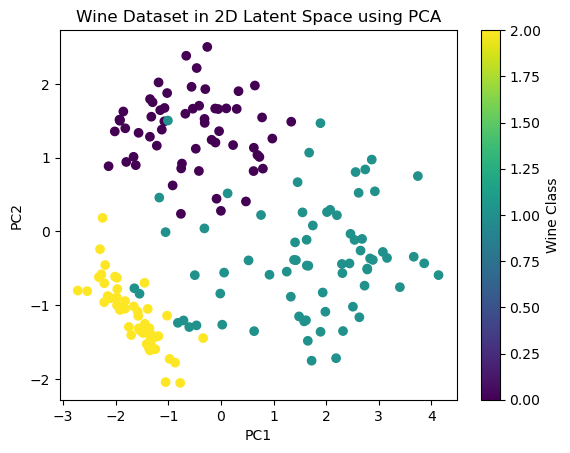

In [27]:
# Visualize the latent data using PCA
plt.scatter(latentScores[:, 0], latentScores[:, 1], c=y, cmap='viridis')
plt.title('Wine Dataset in 2D Latent Space using PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.colorbar(label='Wine Class')
plt.show()

## Why Vanilla Autoencoders Suck at Generating Data

The idea of generating samples in the autoencoder family is to pick a random value from the latent space and decode it to produce a new sample.
For example, let’s assume we have an encoder that compresses our data into a 2-dimensional latent space.
<img src="images/autoencoder2dlatent.png" alt="AutoEncoder 2D latent Space" style="margin: auto; display: block; width: 800px;">
Those five points in the diagram are our data, compressed by the encoder into two features. Now, if we want to generate a new sample from the autoencoder, we just pick a random point from the latent space, like the picture below shows.
<img src="images/2Dlatentspace.png" alt="A 2D latent Space" style="margin: auto; display: block; width: 500px;">
And here’s the problem: the model was trained on just those five data samples. It only really knows those points, because all the weights, biases, and coefficients are tuned just for them. That means it has no idea about the rest of the latent space, which I’ve shown in blue below.
<img src="images/2DlatentNotknown.png" alt="A 2D latent Space" style="margin: auto; display: block; width: 500px;">
So if we take a random point from the latent space and give it to the decoder, chances are high that what it generates won’t be valid. For example, if our data is made of images, the output picture will just look noisy. And if it’s tabular data, the generated sample will probably have weird, unrealistic feature values.

**Note**: Because of this problem with autoencoders, that the model knows nothing about regions of the latent space outside the training data, the autoencoder is considered an **irregular** latent space method. Methods that address this issue are referred to as **regularized** latent space methods.

Let’s actually generate a sample from the blue region. To do this, we’ll use the first model we trained, which had a 2D latent space. Our random point from the invalid region will be (8, 5). Let’s see what it gets decoded into.

In [28]:
fake_latent_sample = np.array([8, 5])

In [29]:
fake_generated_sample = model.decoder(torch.tensor(fake_latent_sample, dtype=torch.float32))
fake_generated_sample_df = pd.DataFrame(fake_generated_sample.detach(), feature_names)
fake_generated_sample_df

,0
alcohol,-0.747028
malic_acid,-2.610663
ash,-0.245065
alcalinity_of_ash,0.240054
magnesium,0.574873
total_phenols,2.663325
flavanoids,4.009242
nonflavanoid_phenols,-1.915475
proanthocyanins,3.648505
color_intensity,-1.424320


You see how bad the generated sample is, some features even got negative.Now that we’ve gotten familiar with dimensionality reduction and vanilla autoencoders, let’s dive into the main topic, **VAEs**.

## Introduction to Variational Autoencoders
VAEs make the latent space regularized, but how? They map the data into a probabilistic distribution. Typically, we want the latent space to follow a normal distribution, so the encoder is trained in such a way that the data eventually forms a standard normal distribution in the latent space. By doing this, our model becomes familiar with every point in the latent space, and any point we randomly choose can be decoded into a valid new sample.

**Note** that the latent space is designed to follow a standard normal distribution. Therefore, if the latent space has more than one dimension, this distribution becomes a multivariate normal distribution.We continue with our two-dimensional latent space example.

So how does the model actually turn the latent space into a standard normal distribution? Let’s break it down.

First, the encoder generates a μ (the mean) and a σ (the standard deviation) for each training sample in the latent space.So basically, each sample turns into a little normal distribution.
<img src="images/probabilistic_latent_space.png" alt="A 2D probabilistic latent Space" style="margin: auto; display: block; width: 800px;">
Since the latent space is 2-dimensional, both μ and σ are also 2-dimensional, and the Σ (covariance matrix) becomes a 2×2 diagonal matrix.By forcing the covariance matrix to be diagonal, we assume that there is no correlation between the dimensions. And since our distribution is normal, this also means the dimensions are independent.

$\mu = \begin{vmatrix} \mu_{1} \\ \mu_{2} \end{vmatrix}$

$\sigma = \begin{vmatrix} \sigma_{1} \\ \sigma_{2} \end{vmatrix}$

$\Sigma  = \begin{vmatrix} \sigma_{1} & 0 \\ 0 & \sigma_{2} \\ \end{vmatrix}$

__________________________________________________________________________________


Next, from each normal distribution we randomly select a point and pass it to the decoder in order to reconstruct the original input data.
<img src="images/sampling_from_latent_space.png" alt="sampling_from_latent_space" style="margin: auto; display: block; width: 800px;">

Finally, we add a Kullback–Leibler (KL) divergence term between each of these normal distributions and the standard normal distribution to the model’s loss function.

So the loss function changes to this: reconstruction loss plus a KL divergence term.

$loss = \sum_{i}^{N}{\color{Red} (}\left\| x-x^{''}\right\|^{2} + D_{kl}{\color{Blue} (}N(\mu,\sigma^{2}I)||N(0,I){\color{Blue} )}{\color{Red} )}$

The closed form of the KL divergence for our model is as follows:

$D_{kl}(N(\mu,\sigma^{2}I)||N(0,I)) = \frac{1}{2}\sum_{i}^{n}(1+ln(\sigma_{i}^{2})-\sigma_{i}^{2} - \mu_{i}^{2})$

**what is Kullback–Leibler (KL) divergence?**

Kullback–Leibler (KL) divergence is a type of statistical distance that measures how one probability distribution differs from another. If the loss function only contains this term, the model will try to minimize this distance by making the normal distributions of the samples converge to a standard normal distribution. This causes them to cluster around the center of the diagram, as shown below.
<img src="images/kl_diagram.png" alt="kl_diagram" style="margin: auto; display: block; width: 500px;">
The issue with just using this term is that the samples get all tangled up, so reconstructing the data becomes a problem.
_________________________________________
As we saw with vanilla autoencoders, using only the reconstruction term in the loss function encourages the model to spread the samples as much as possible, which creates a lot of unknown space in the latent space like the picture below.
<img src="images/recons_diagram.png" alt="recons_diagram" style="margin: auto; display: block; width: 500px;">



___________________
By using both terms in the loss function, the model finds a trade-off to minimize the loss. The result is that the samples are neither too spread out nor too tangled together. The latent space becomes meaningful and regularized, leaving no unknown gaps between the samples. This allows us to pick any random point within this region to generate a new sample.
<img src="images/both_term_loss.png" alt="recons_diagram" style="margin: auto; display: block; width: 500px;">

_________
One more thing before we dive into the code: so far, we know that we give an input to the model, it generates μ and σ, and then, based on this normal distribution, it randomly chooses a point from the regularized latent space (called z) and passes it through the decoder to reconstruct the original data.

We also know that to train the weights and biases we need to use backpropagation. Now, suppose we want to update a weight in the encoder. Based on the chain rule, we can write:

$\frac{\mathrm{d} loss}{\mathrm{d} w_{inEncoder}} = \frac{\partial loss}{\partial deocder}*\frac{\partial decoder}{\partial z}*\frac{\partial z}{\partial ?}$

As you can see, we’re stuck, z is a random sample from the latent space, so there’s no equation for it and we can’t take derivatives.

**Reparameterization trick:** to fix this problem, We rewrite the sampling step as a deterministic function of μ σ, and an external noise source:

$z = \mu + \sigma\bigodot \epsilon $ 

$\epsilon \sim N(0, I)$

Now we can easily compute the derivatives with respect to μ and σ. After that, we can finally backprop into the encoder’s weights and biases like bellow

$\frac{\mathrm{d} loss}{\mathrm{d} w_{inEncoder}} = \frac{\partial loss}{\partial deocder}*\frac{\partial decoder}{\partial z}*\frac{\partial z}{\partial \mu}*\frac{\partial \mu}{\partial w_{inEncoder}} + \frac{\partial loss}{\partial deocder}*\frac{\partial decoder}{\partial z}*\frac{\partial z}{\partial \sigma}*\frac{\partial \sigma}{\partial w_{inEncoder}}$

<img src="https://lilianweng.github.io/posts/2018-08-12-vae/vae-gaussian.png" alt="recons_diagram" style="margin: auto; display: block; width: 800px;">

Alright, let’s jump into coding and see how this works in practice.

## Create and Train the Variational Autoencoder model

In [30]:
class VAE(L.LightningModule):
    def __init__(self, input_dim, hidden_dim, latent_dim, learning_rate):
        ## input_dim: it actully is the number of features(13 features)
        ## hidden_dim: hidden layer dimension
        ## latent_dim: latent_space dimension
        ## learning_rate: used to tune the gradient descent steps
        super().__init__()
        self.save_hyperparameters() # save all the model parameters like learning rate, input_dim in the model(can be accessed by self.hparams.learning_rate froexample)
        self.learning_rate = learning_rate
        
        # Encoder: Input -> Hidden -> Mean and Log Variance
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        
        # Decoder: Latent -> Hidden -> Output
        self.fc2 = nn.Linear(latent_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, input_dim)
        
        # Mse Loss function
        self.mse_loss = nn.MSELoss(reduction='sum')
        
        # Lists to store losses for plotting
        self.total_batch_losses = []  # store total loss value for each batch
        self.total_epoc_losses = []   # store average total loss for batches in each epoc
        self.mse_batch_losses = []    # store mse loss for each batch
        self.mse_epoc_losses = []     # store average mse loss for batches in each epoc
        self.kl_batch_losses = []     # store kl loss for each batch
        self.kl_epoc_losses = []      # store average kl loss for batches in each epoc

    def encode(self, x):
        h = torch.relu(self.fc1(x))
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
        
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = torch.relu(self.fc2(z))
        return self.fc3(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        decoded = self.decode(z)
        return decoded, mu, logvar

    def vae_loss(self, recon_x, x, mu, logvar):
        mse_loss = self.mse_loss(recon_x, x)
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return mse_loss + kl_div, mse_loss, kl_div

    def training_step(self, batch, batch_idx):
        ## The first thing we do is split 'batch'
        ## into the input and label values.
        ## Note that here, the labels are the inputs themselves
        inputs, labels = batch
        recon_x, mu, logvar = self.forward(inputs)
        total_loss, mse_loss, kl_div = self.vae_loss(recon_x, labels, mu, logvar)
        
        self.total_batch_losses.append(total_loss.item())
        self.mse_batch_losses.append(mse_loss.item())
        self.kl_batch_losses.append(kl_div.item())

        return total_loss

    def configure_optimizers(self):
        ## In this example, configuring the optimizer
        ## consists of passing it the weights and biases we want
        ## to optimize, which are all in self.parameters(),
        ## and setting the learning rate
        return Adam(self.parameters(), lr=self.learning_rate)

    
    ## "on_train_epoch_end" is a hook(event) within the LightningModule that is called at the end of each training epoch.
    def on_train_epoch_end(self):
        # Compute average losses for the epoch
        avg_total_loss = np.mean(self.total_batch_losses[-len(train_dataloader):])
        avg_mse_loss = np.mean(self.mse_batch_losses[-len(train_dataloader):])
        avg_kl_loss = np.mean(self.kl_batch_losses[-len(train_dataloader):])

        self.total_epoc_losses.append(avg_total_loss)
        self.mse_epoc_losses.append(avg_mse_loss)
        self.kl_epoc_losses.append(avg_kl_loss)
        


In [31]:
# Initialize and train the model
vae_model = VAE(input_dim=X.shape[1], hidden_dim=8, latent_dim=2, learning_rate=0.01)
trainer = L.Trainer(max_epochs=50, logger=False)
trainer.fit(vae_model, train_dataloaders=train_dataloader)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | fc1       | Linear  | 112    | train
1 | fc_mu     | Linear  | 18     | train
2 | fc_logvar | Linear  | 18     | train
3 | fc2       | Linear  | 24     | train
4 | fc3       | Linear  | 117    | train
5 | mse_loss  | MSELoss | 0      | train
----------------------------------------------
289       Trainable params
0         Non-trainable params
289       Total params
0.001     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


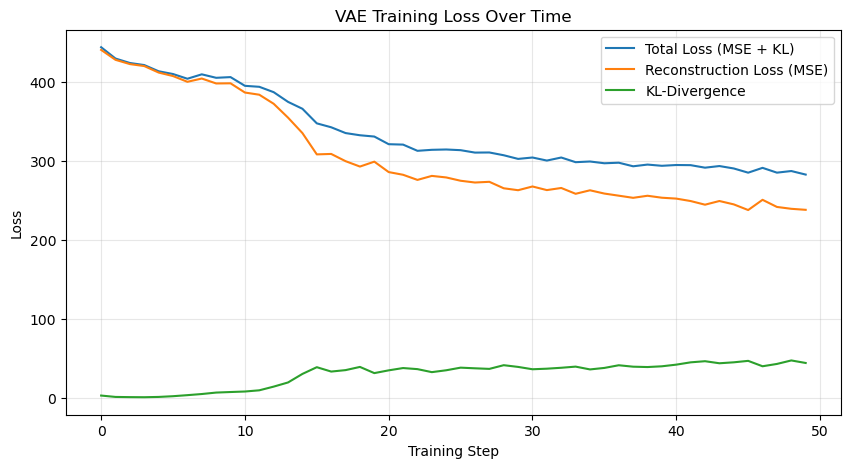

In [32]:
# Plot the loss curves
plt.figure(figsize=(10, 5))
plt.plot(vae_model.total_epoc_losses, label='Total Loss (MSE + KL)')
plt.plot(vae_model.mse_epoc_losses, label='Reconstruction Loss (MSE)')
plt.plot(vae_model.kl_epoc_losses, label='KL-Divergence')
plt.title('VAE Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

The loss function seems to have reached a stable condition, but to be sure, let’s add 200 more epochs for training.

In [34]:
## First, find where the most recent checkpoint files are stored
path_to_checkpoint = trainer.checkpoint_callback.best_model_path ## By default, "best" = "most recent"

## Then create a new Lightning Trainer
trainer = L.Trainer(max_epochs=250) # Before, max_epochs=50, so, by setting it to 250, we're adding 200 more.
## And then call fit() using the path to the most recent checkpoint files
## so that we can pick up where we left off.
trainer.fit(vae_model, train_dataloaders=train_dataloader, ckpt_path=path_to_checkpoint)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Restoring states from the checkpoint path at /home/mazyar/Documents/programming/vae_tutorial/checkpoints/epoch=49-step=250.ckpt
/mnt/sda1/programming enviroments/one_env_to_rule_them_all/lib/python3.12/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:362: The dirpath has changed from '/home/mazyar/Documents/programming/vae_tutorial/checkpoints' to '/home/mazyar/Documents/programming/vae_tutorial/lightning_logs/version_3/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | fc1       | Linear  | 112    | train
1 | fc_mu  

Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


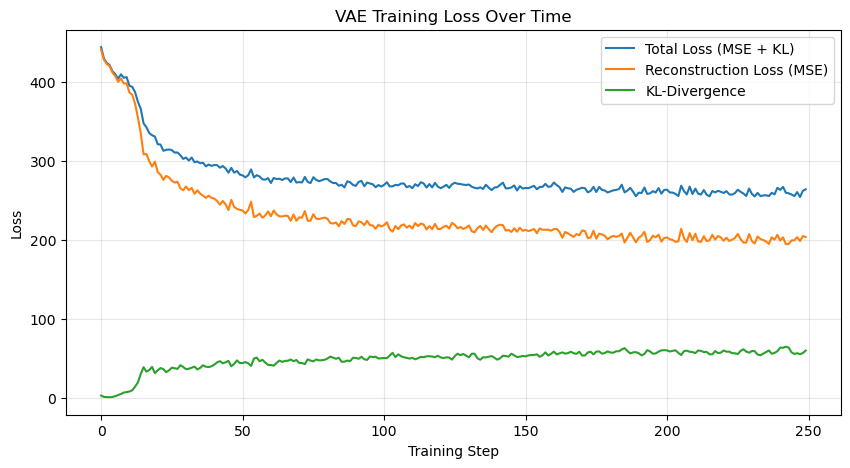

In [35]:
# Plot the loss curves again
plt.figure(figsize=(10, 5))
plt.plot(vae_model.total_epoc_losses, label='Total Loss (MSE + KL)')
plt.plot(vae_model.mse_epoc_losses, label='Reconstruction Loss (MSE)')
plt.plot(vae_model.kl_epoc_losses, label='KL-Divergence')
plt.title('VAE Training Loss Over Time')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [36]:
# Generate new data and assign labels
vae_model.eval()
with torch.no_grad():
    num_samples = 100
    z = torch.randn(num_samples, vae_model.hparams.latent_dim) # Generates 100 random 2D points from a normal distribution to pass into the decoder for new data generation.
    generated = vae_model.decode(z).numpy()
    generated_original_scale = scaler.inverse_transform(generated) # Back to original scale

    # Get latent representations and reconstructed data
    recon, mu, logvar = vae_model(X_tensor)
    X_reduced = mu.numpy() # Use mean as latent representation
    X_reconstructed = scaler.inverse_transform(recon.numpy()) 

Since a Variational Autoencoder is an unsupervised learning method, it doesn’t use labels during training. However, if we want to assign labels to the data it generates, we need an additional step. A common approach is to train a classifier (e.g., logistic regression, random forest, or a small neural network) on the original labeled dataset, and then use this classifier to predict the labels of the newly generated samples from the VAE. For the sake of this example, we’ll just use a simple k-Nearest Neighbors (kNN) classifier to assign labels to the generated samples.

In [37]:
# Assign labels to generated samples using k-NN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(scaler.inverse_transform(X_scaled), y)
generated_labels = knn.predict(generated)

In [38]:
# Create DataFrame for original, reconstructed, and generated data
df_data = {}
for i, feature in enumerate(feature_names):
    df_data[feature] = scaler.inverse_transform(X_scaled)[:, i]
    df_data[f'recon_{feature}'] = X_reconstructed[:, i]
df_data['latent_1'] = X_reduced[:, 0]
df_data['latent_2'] = X_reduced[:, 1]
df_data['wine_class'] = y
df = pd.DataFrame(df_data)

# DataFrame for generated data
df_generated = pd.DataFrame(generated_original_scale, columns=feature_names)
df_generated['wine_class'] = generated_labels
df_generated['type'] = 'Generated'

In [39]:
df_generated.describe()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,wine_class
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.0
mean,12.903130,2.258983,2.356452,19.615665,98.763428,2.319393,2.094903,0.355704,1.612557,4.731884,0.971714,2.651637,723.294739,1.0
std,0.579221,0.483149,0.098776,1.634543,7.234252,0.480732,0.817058,0.075956,0.325626,1.812009,0.162806,0.580122,253.127365,0.0
min,12.120298,1.709074,2.172122,15.502739,89.823929,1.604024,0.663444,0.255144,0.974049,2.605631,0.391106,1.223778,466.114960,1.0
25%,12.405102,1.967783,2.272796,18.563135,92.054314,1.789103,1.212833,0.292540,1.392397,3.349518,0.928603,2.146881,533.014084,1.0
50%,12.791465,2.050539,2.354949,20.125186,98.006821,2.409254,2.318795,0.327397,1.735746,4.402881,1.057772,3.006799,617.560669,1.0
75%,13.289488,2.407501,2.443890,20.435134,104.597717,2.761208,2.828741,0.395383,1.908767,5.612317,1.070027,3.122769,866.790237,1.0
max,14.452349,3.849679,2.583762,23.317461,123.872047,3.163636,3.413551,0.546162,2.133162,11.221183,1.089056,3.204559,1452.752686,1.0


Even with a simple 2D latent space, the model generated good samples.

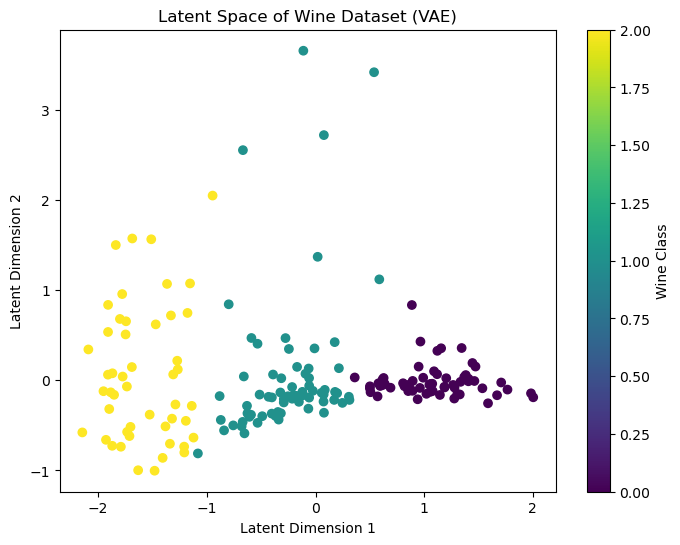

In [40]:
# Latent space
plt.figure(figsize=(8, 6))
plt.scatter(df['latent_1'], df['latent_2'], c=df['wine_class'], cmap='viridis')
plt.title('Latent Space of Wine Dataset (VAE)')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.colorbar(label='Wine Class')
plt.show()

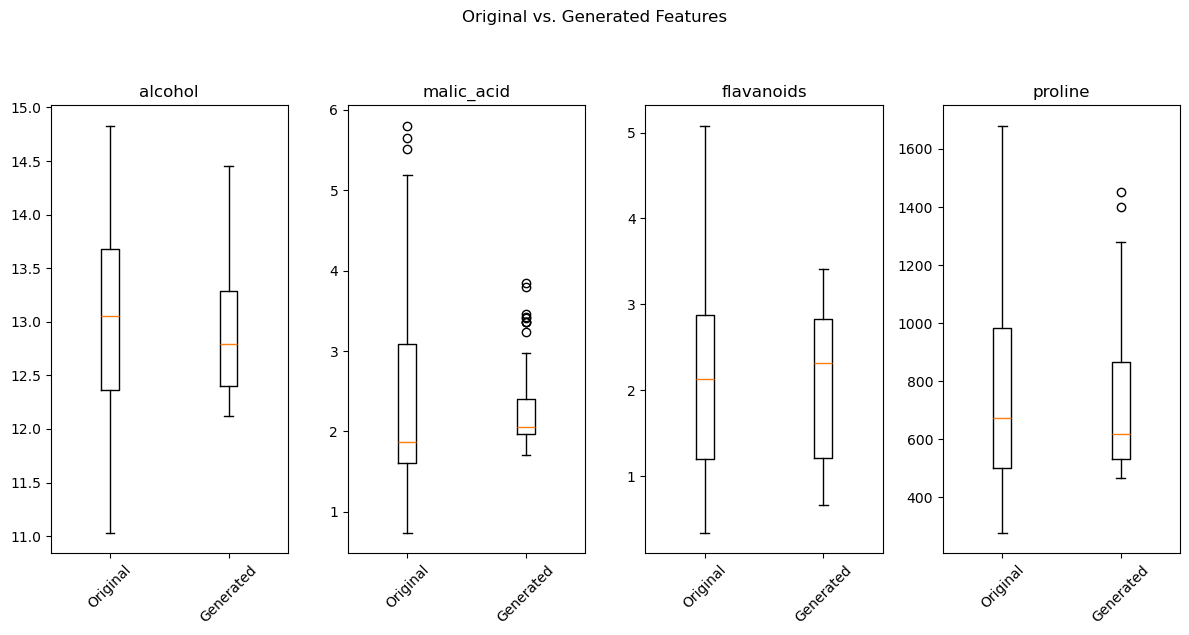

In [41]:
# Plot 2: Boxplots for selected features (original vs. generated)
selected_features = ['alcohol', 'malic_acid', 'flavanoids', 'proline']
plt.figure(figsize=(12, 6))
for i, feature in enumerate(selected_features):
    plt.subplot(1, len(selected_features), i + 1)
    plt.boxplot([df[feature], df_generated[feature]], labels=['Original', 'Generated'])
    plt.title(feature)
    plt.xticks(rotation=45)
plt.suptitle('Original vs. Generated Features', y=1.05)
plt.tight_layout()
plt.show()

## Conclusion

In the context of generative models, VAEs have proven to be highly effective. The generated data is comparable in quality to that of other generative approaches, while being considerably faster to train than models such as GANs. As demonstrated, even with just 50 epochs the loss reached a stable condition. This tutorial provided a basic introduction to VAEs; however, there are many more advanced variants of VAEs that address some of the limitations of the simple VAE.

**Note:** For a deeper and more precise intuition about VAEs, you can refer to the seminal paper by [Kingma and Welling (2014)](https://arxiv.org/abs/1312.6114). In addition, [Lilian Weng](https://lilianweng.github.io/posts/2018-08-12-vae/) has written an excellent blog post on autoencoders and several VAE variants, which I highly recommend reading.